# Home Credit Default Risk

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
pd.options.display.max_columns = 200
plt.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Credit data"

In [ ]:
#загружаем тренировочную, тестовую выборки, а также пример предсказаний
train = pd.read_csv('/content/drive/My Drive/Credit data/application_train.csv')
test = pd.read_csv('/content/drive/My Drive/Credit data/application_test.csv')
sample_submission = pd.read_csv("/content/drive/My Drive/Credit data/sample_submission.csv")

In [ ]:
train.shape

(307511, 122)

In [ ]:
#посмотрим на данные
train.describe()

# Data Cleaning and Preparation

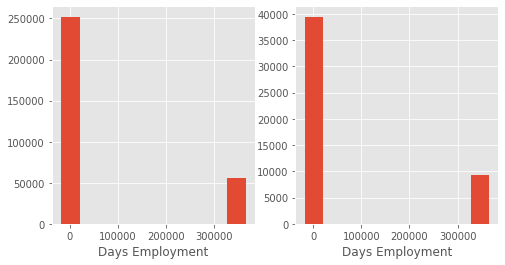

In [ ]:
#заметим выбросы:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(8, 4)
)

ax1.hist(train['DAYS_EMPLOYED']);
ax1.set_xlabel('Days Employment');

ax2.hist(test['DAYS_EMPLOYED']);
ax2.set_xlabel('Days Employment');

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


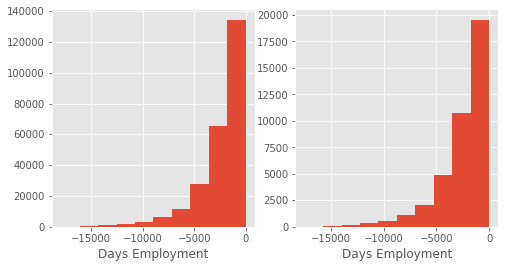

In [ ]:
# заменим их на пропуски
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(8, 4)
)

ax1.hist(train['DAYS_EMPLOYED']);
ax1.set_xlabel('Days Employment');

ax2.hist(test['DAYS_EMPLOYED']);
ax2.set_xlabel('Days Employment');

In [ ]:
#напишем функцию для проверки пропущенных значений
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
missing_values = missing_values_table(train)
missing_values.head(10)

Your selected dataframe has 122 columns.
There are 68 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MEDI,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4


In [ ]:
#удалим столбцы с пропусками более 50%
mis_val_table_ren_columns = missing_values.loc[missing_values['% of Total Values'] > 50]
train = train.drop(mis_val_table_ren_columns.index, axis=1)
train.shape

(307511, 81)

In [ ]:
#в качестве зависимой переменной берем TARGET:
y = train['TARGET']

#удаляем ID и TАRGET из тренировочной выборки:
train = train.drop(['TARGET'], axis=1)
train.shape

(307511, 80)

In [ ]:
#разделяем категориальные и числовые переменные
cat = []
num = []

for i in train.columns:
    if train[i].dtype == 'object':
        cat.append(i)
    else:
        num.append(i)

print("Categorical: " + str(len(cat)))
print("Numerical: " + str(len(num)))

Categorical: 13
Numerical: 67


In [ ]:
#создаем список самых частых значений для категориальных переменных
most_freq_cat_nans = []
for i in cat:
    most_freq_cat_nans.append(train[i].value_counts().idxmax())

In [ ]:
#заменяем пропуски самыми частыми значениями в категориальных переменных и медианой в числовых
for i in range(len(cat)):
    train[cat[i]].fillna(most_freq_cat_nans[i], inplace=True)
    
for i in num:
    train[i].fillna(train[i].median(), inplace=True)

print(train.isna().sum().max())

0


In [ ]:
#те же действия для тестовой выборки:
test = test.drop(mis_val_table_ren_columns.index, axis=1)
#test = test.drop(['SK_ID_CURR'], axis=1)

cat = []
num = []

for i in test.columns:
    if test[i].dtype == 'object':
        cat.append(i)
    else:
        num.append(i)

print(len(cat), len(num))

most_freq_cat_nans = [] 
for i in cat:
    most_freq_cat_nans.append(test[i].value_counts().idxmax())
    
for i in range(len(cat)):
    test[cat[i]].fillna(most_freq_cat_nans[i], inplace=True)
    
for i in num:
    test[i].fillna(test[i].median(), inplace=True)

print(test.isna().sum().max()) 

13 67
0


In [ ]:
#объединим тестовую и тренировочную выборки
df = train.append(test)
df.drop(['SK_ID_CURR'], axis = 1, inplace = True)
df.tail()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
48739,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,Unaccompanied,Working,Secondary / secondary special,Widow,House / apartment,0.002042,-19970,-5169.0,-9094.0,-3399,1,1,1,1,1,0,Laborers,1.0,3,3,WEDNESDAY,16,0,0,0,0,0,0,Other,0.648575,0.643026,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0707,No,1.0,0.0,1.0,0.0,-684.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.035792,-11186,-1149.0,-3015.0,-3003,1,1,0,1,0,0,Sales staff,4.0,2,2,MONDAY,11,0,0,0,0,1,1,Trade: type 7,0.684596,0.519097,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0707,No,2.0,0.0,2.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
48741,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.026392,-15922,-3037.0,-2681.0,-1504,1,1,0,1,1,0,Laborers,3.0,2,2,WEDNESDAY,12,0,0,0,0,0,0,Business Entity Type 3,0.632770,0.283712,0.9955,0.3333,0.9955,0.3333,0.9955,0.3333,0.1663,No,0.0,0.0,0.0,0.0,-838.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,Family,Commercial associate,Higher education,Married,House / apartment,0.018850,-13968,-2731.0,-1461.0,-1364,1,1,1,1,1,0,Managers,2.0,2,2,MONDAY,10,0,1,1,0,1,1,Self-employed,0.445701,0.595456,0.9896,0.6250,0.9896,0.6250,0.9896,0.6250,0.1974,No,0.0,0.0,0.0,0.0,-2308.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
48743,Cash loans,F,Y,N,0,135000.0,312768.0,24709.5,270000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.006629,-13962,-633.0,-1072.0,-4220,1,1,1,1,0,0,Core staff,2.0,2,2,TUESDAY,14,0,0,0,0,0,0,Government,0.456541,0.272134,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.0707,No,0.0,0.0,0.0,0.0,-327.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0


Закодируем все категориальные переменные с помощью One Hot Encoding 

In [ ]:
categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
df = pd.get_dummies(df, columns= categorical_columns, dummy_na= True)
df.tail()

In [ ]:
x_train = df[:307511]
x_test = df[307511:]

# Boosting

## n_estimators

In [ ]:
#функция для оценки ошибки модели(XGBClassifier) с помощью кроссвалидации данных(k-fold):
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc

n_estimators = [10, 30, 50, 100, 500]

def kfold(X, y):
    
    result = []
    for estimators in n_estimators:
        # Инициализируем модель
        model = XGBClassifier(seed = 42,
                              n_estimators = estimators,
                              learning_rate = 0.08,
                              max_depth = 3)
        
        kf = KFold(n_splits = 3, random_state = 42, shuffle = True)
        roc_auc_list = []
        
        for i, (train_index, test_index) in enumerate(kf.split(X)):
            
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            model.fit(X_train, y_train)
            pred_prob = model.predict_proba(X_test)
            predict = pred_prob[:,1]
            roc_auc = roc_auc_score(y_test, predict)
            print(i, roc_auc)
            roc_auc_list.append(roc_auc)
            
        result.append(np.mean(roc_auc_list))
        
    return result

In [ ]:
cross_val = kfold(x_train, y)

0 0.7052060366615535
1 0.7049333215354934
2 0.7020975290932706
0 0.7167811138918468
1 0.7168278162274939
2 0.7134636749823843
0 0.7307393414398592
1 0.7287367219103388
2 0.7263891484248721
0 0.744174982312349
1 0.7420143686664114
2 0.7418176361956489
0 0.7537214557557959
1 0.751950742118297
2 0.7523085795082635


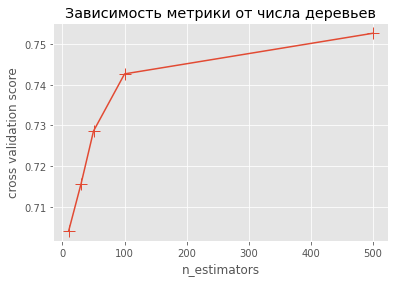

In [ ]:
plt.plot(n_estimators, cross_val, '-+', markersize=12)
plt.title("Зависимость метрики от числа деревьев")
plt.xlabel("n_estimators")   
plt.ylabel("cross validation score")
plt.show()

Чем больше число деревьев, тем выше качество модели. Но при слишком большом количестве деревьев(к примеру более 1000) модель может переобучиться(также заметно увеличивается время ожидания работы алгоритма).

## learning_rate

In [ ]:
learning_rates = [0.1, 0.08, 0.05, 0.03, 0.01]

def kfold2(X, y):
    
    result = []
    for learning_rate in learning_rates:
        # Инициализируем модель
        model = XGBClassifier(seed = 42,
                              n_estimators = 50,
                              learning_rate = learning_rate,
                              max_depth = 3)
        
        kf = KFold(n_splits = 3, random_state = 42, shuffle = True)
        roc_auc_list = []
        
        for i, (train_index, test_index) in enumerate(kf.split(X)):
            
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            model.fit(X_train, y_train)
            pred_prob = model.predict_proba(X_test)
            predict = pred_prob[:,1]
            roc_auc = roc_auc_score(y_test, predict)
            print(i, roc_auc)
            roc_auc_list.append(roc_auc)
            
        result.append(np.mean(roc_auc_list))
        
    return result

In [ ]:
cross_val_2 = kfold2(x_train, y)

0 0.7369157261199255
1 0.7338257387175873
2 0.7330442970504649
0 0.7307393414398592
1 0.7287367219103388
2 0.7263891484248721
0 0.7182270495383535
1 0.7175004701392407
2 0.7143741993639217
0 0.7097730299109503
1 0.7105127249465859
2 0.7077005105177017
0 0.7041770033920373
1 0.7028859462260818
2 0.7014404729159553


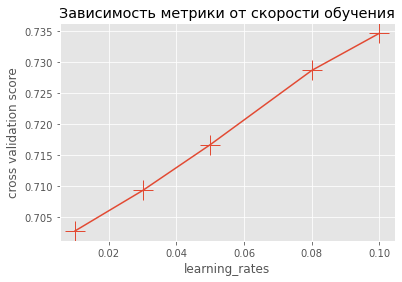

In [ ]:
plt.plot(learning_rates, cross_val_2, '-+', markersize=20)
plt.title("Зависимость метрики от скорости обучения")
plt.xlabel("learning_rates")   
plt.ylabel("cross validation score")
plt.show()

На данном графике видно, что чем больше скорость обучения, тем выше качество модели. Но это не зачит, что нужно брать слишком большое значение показателя, так как можем сильно увеличить влияние каждого дерева. Рекомендуемое значение 0.1

## max_depths

In [ ]:
max_depths = [2, 3, 4, 5]

def kfold3(X, y):
    
    result = []
    for max_depth in max_depths:
        # Инициализируем модель
        model = XGBClassifier(seed = 42,
                              n_estimators = 50,
                              learning_rate = 0.1,
                              max_depth = max_depth)
        
        kf = KFold(n_splits = 3, random_state = 42, shuffle = True)
        roc_auc_list = []
        
        for i, (train_index, test_index) in enumerate(kf.split(X)):
            
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            model.fit(X_train, y_train)
            pred_prob = model.predict_proba(X_test)
            predict = pred_prob[:,1]
            roc_auc = roc_auc_score(y_test, predict)
            print(i, roc_auc)
            roc_auc_list.append(roc_auc)
            
        result.append(np.mean(roc_auc_list))
        
    return result

In [ ]:
cross_val_3 = kfold3(x_train, y)

0 0.7288259796603284
1 0.7262508446150725
2 0.7247029551136844
0 0.7369157261199255
1 0.7338257387175873
2 0.7330442970504649
0 0.7411914030980954
1 0.7375850702887445
2 0.7367649485001229
0 0.7423944381873212
1 0.7409525517081536
2 0.7398704522348324


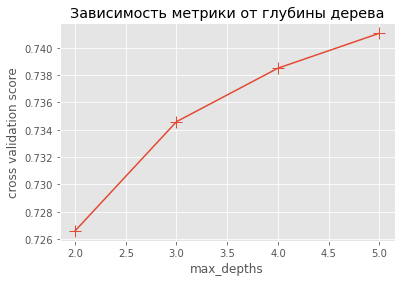

In [ ]:
plt.plot(max_depths, cross_val_3, '-+', markersize=12)
plt.title("Зависимость метрики от глубины дерева")
plt.xlabel("max_depths")   
plt.ylabel("cross validation score")
plt.show()

В данном случае качество модели выше при более глубоких деревьях. Однако стоит помнить, что для алгоритмов бустинга(в отличии от бэггинга) не рекомендуется использовать слишком глубокие деревья. Также при большой глубине модель может переобучиться.

## GridSearchCV

Запустим перебор некоторых параметров по сетке:

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'learning_rate':[0.2, 0.1],
              'max_depth':[5, 6], 
              'n_estimators':[50, 100]
              }

model = XGBClassifier(seed = 42,
                      n_jobs = -1)

grid_search = GridSearchCV(model, parameters, cv = 3, scoring = 'roc_auc')
grid_search.fit(x_train, y)

In [ ]:
#выведем лучшую среднюю метрику на кросс-валидации и лучшие параметры
print(grid_search.best_score_)
print(grid_search.best_params_) 

0.7496990276826189
{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}


## RandomizedSearchCV

Учитывая результаты GridSearchCV, запустим "более мягкий" перебор RandomizedSearchCV:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {'learning_rate':[0.2, 0.1],
              'max_depth':[3, 5, 7], 
              'n_estimators':[100, 500, 1000]
              }

model = XGBClassifier(seed = 42,
                      n_jobs = -1)

rnd_search = RandomizedSearchCV(model, parameters, cv = 3, scoring = 'roc_auc')
rnd_search.fit(x_train, y)

In [ ]:
print(rnd_search.best_score_)
print(rnd_search.best_params_) 

0.752506751978475
{'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.1}


Построим модель на всей выборке с "лучшиими" параметрами:

learning_rate = 0.1,
max_depth = 3,
n_estimators = 1000





In [ ]:
xb = XGBClassifier(seed=42,
                   n_estimators=1000,
                   max_depth=3,
                   learning_rate=0.1)

xb.fit(x_train, y)

In [ ]:
#записываем прогноз
pred_prob = xb.predict_proba(x_test)
prediction = pred_prob[:,1]

sample_submission['TARGET'] = prediction
sample_submission.head()

#кладем результат в файл:
sample_submission.to_csv('/content/drive/My Drive/Credit data/dec2.csv', index = None)

### Public Score: 0.74068
### Private Score: 0.73641

## Feature importances

Оценим значимость переменных при обучении классификатора:

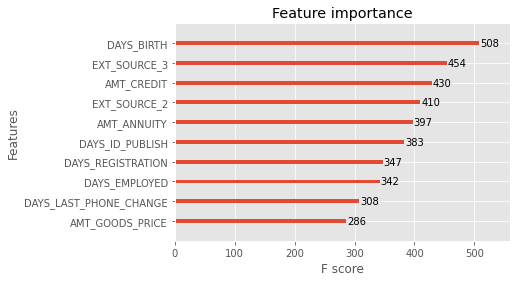

In [ ]:
import xgboost as xgb

xgb.plot_importance(xb,max_num_features = 10)
plt.show()

Таким образом топ-5 переменных, которые внесли наибольший вклад в построение модели: 

DAYS_BIRTH,
EXT_SOURCE_3,
AMT_CREDIT
EXT_SOURCE_2,
AMT_ANNUITY

# Stacking

Попробуем добиться наилучшего скора с помощью Stacking(rf, lr, xgb, cb, lgbm). Финальным классификатором будет логистическая регрессия.
Будем использовать LabelEncoder, чтобы избежать слишком большого числа переменных и скоратить время ожидания.

In [ ]:
from sklearn import preprocessing

df = train.append(test)

le = preprocessing.LabelEncoder()
le_count = 0

for col in df:
    if df[col].dtype == 'object':
        le.fit(df[col])
        df[col] = le.transform(df[col])
        le_count += 1
print ('{} variable are label encoded'.format(le_count))
df.shape

13 variable are label encoded


(356255, 80)

Сначала увеличим количество переменных, добавив новые таблицы:

Bureau

In [ ]:
bureau = pd.read_csv('/content/drive/My Drive/Credit data/bureau.csv', nrows = None)

In [ ]:
#смотрим на пропуски
missing_values = missing_values_table(bureau)

#удалим столбцы с пропусками более 50%
mis_val_table_ren_columns = missing_values.loc[missing_values['% of Total Values'] > 50]
bureau = bureau.drop(mis_val_table_ren_columns.index, axis=1)

#разбиваем переменные на 2 типа
cat = []
num = []

for i in bureau.columns:
    if bureau[i].dtype == 'object':
        cat.append(i)
    else:
        num.append(i)

print("Categorical: " + str(len(cat)))
print("Numerical: " + str(len(num)))

#заполняем пропуски
most_freq_cat_nans = [] 
for i in cat:
    most_freq_cat_nans.append(bureau[i].value_counts().idxmax())
    
for i in range(len(cat)):
    bureau[cat[i]].fillna(most_freq_cat_nans[i], inplace=True)
    
for i in num:
    bureau[i].fillna(bureau[i].median(), inplace=True)

print(bureau.isna().sum().max()) 

Your selected dataframe has 17 columns.
There are 7 columns that have missing values.
Categorical: 3
Numerical: 12
0


In [ ]:
le_count = 0

for col in bureau:
    if bureau[col].dtype == 'object':
        le.fit(bureau[col])
        bureau[col] = le.transform(bureau[col])
        le_count += 1
print ('{} variable are label encoded'.format(le_count))

bureau = bureau.groupby('SK_ID_CURR', as_index = False).mean()
bureau.tail()

In [ ]:
df = df.merge(bureau, how='left', on='SK_ID_CURR')
del bureau
print(df.shape)

(356255, 94)


POS_CASH_balance

In [ ]:
pos = pd.read_csv('/content/drive/My Drive/Credit data/POS_CASH_balance.csv', nrows = None)

In [ ]:
#смотрим на пропуски
missing_values = missing_values_table(pos)

#удалим столбцы с пропусками более 50%
mis_val_table_ren_columns = missing_values.loc[missing_values['% of Total Values'] > 50]
pos = pos.drop(mis_val_table_ren_columns.index, axis=1)

#разбиваем переменные на 2 типа
cat = []
num = []

for i in pos.columns:
    if pos[i].dtype == 'object':
        cat.append(i)
    else:
        num.append(i)

print("Categorical: " + str(len(cat)))
print("Numerical: " + str(len(num)))

#заполняем пропуски
most_freq_cat_nans = [] 
for i in cat:
    most_freq_cat_nans.append(pos[i].value_counts().idxmax())
    
for i in range(len(cat)):
    pos[cat[i]].fillna(most_freq_cat_nans[i], inplace=True)
    
for i in num:
    pos[i].fillna(pos[i].median(), inplace=True)

print(pos.isna().sum().max()) 

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.
Categorical: 1
Numerical: 7
0


In [ ]:
le_count = 0

for col in pos:
    if pos[col].dtype == 'object':
        le.fit(pos[col])
        pos[col] = le.transform(pos[col])
        le_count += 1
print ('{} variable are label encoded'.format(le_count))

pos = pos.groupby('SK_ID_CURR', as_index = False).mean()

1 variable are label encoded


In [ ]:
df = df.merge(pos, how='left', on='SK_ID_CURR')
del pos
print(df.shape)

(356255, 101)


Credit_card_balance

In [ ]:
cc = pd.read_csv('/content/drive/My Drive/Credit data/credit_card_balance.csv', nrows = None)

In [ ]:
#смотрим на пропуски
missing_values = missing_values_table(cc)

#удалим столбцы с пропусками более 50%
mis_val_table_ren_columns = missing_values.loc[missing_values['% of Total Values'] > 50]
cc = cc.drop(mis_val_table_ren_columns.index, axis=1)

#разбиваем переменные на 2 типа
cat = []
num = []

for i in cc.columns:
    if cc[i].dtype == 'object':
        cat.append(i)
    else:
        num.append(i)

print("Categorical: " + str(len(cat)))
print("Numerical: " + str(len(num)))

#заполняем пропуски
most_freq_cat_nans = [] 
for i in cat:
    most_freq_cat_nans.append(cc[i].value_counts().idxmax())
    
for i in range(len(cat)):
    cc[cat[i]].fillna(most_freq_cat_nans[i], inplace=True)
    
for i in num:
    cc[i].fillna(cc[i].median(), inplace=True)

print(cc.isna().sum().max()) 

Your selected dataframe has 23 columns.
There are 9 columns that have missing values.
Categorical: 1
Numerical: 22
0


In [ ]:
le_count = 0

for col in cc:
    if cc[col].dtype == 'object':
        le.fit(cc[col])
        cc[col] = le.transform(cc[col])
        le_count += 1
print ('{} variable are label encoded'.format(le_count))

cc = cc.groupby('SK_ID_CURR', as_index = False).mean()

1 variable are label encoded


In [ ]:
df = df.merge(cc, how='left', on='SK_ID_CURR')
del cc
print(df.shape)

(356255, 123)


Installments_payments

In [ ]:
ip = pd.read_csv('/content/drive/My Drive/Credit data/installments_payments.csv', nrows = None)

In [ ]:
#смотрим на пропуски
missing_values = missing_values_table(ip)

#удалим столбцы с пропусками более 50%
mis_val_table_ren_columns = missing_values.loc[missing_values['% of Total Values'] > 50]
ip = ip.drop(mis_val_table_ren_columns.index, axis=1)

#разбиваем переменные на 2 типа
cat = []
num = []

for i in ip.columns:
    if ip[i].dtype == 'object':
        cat.append(i)
    else:
        num.append(i)

print("Categorical: " + str(len(cat)))
print("Numerical: " + str(len(num)))

#заполняем пропуски
most_freq_cat_nans = [] 
for i in cat:
    most_freq_cat_nans.append(ip[i].value_counts().idxmax())
    
for i in range(len(cat)):
    ip[cat[i]].fillna(most_freq_cat_nans[i], inplace=True)
    
for i in num:
    ip[i].fillna(ip[i].median(), inplace=True)

print(ip.isna().sum().max()) 

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.
Categorical: 0
Numerical: 8
0


In [ ]:
le_count = 0

for col in ip:
    if ip[col].dtype == 'object':
        le.fit(ip[col])
        ip[col] = le.transform(ip[col])
        le_count += 1
print ('{} variable are label encoded'.format(le_count))

ip = ip.groupby('SK_ID_CURR', as_index = False).mean()

0 variable are label encoded


In [ ]:
df = df.merge(ip, how='left', on='SK_ID_CURR')
del ip
print(df.shape)

(356255, 130)


Удалим пропуски в общей таблице и столбец SK_ID_CURR:

In [ ]:
for i in df.columns:
    df[i] = df[i].fillna(df[i].mean())

print(df.isna().sum().max()) 
df = df.drop(['SK_ID_CURR'], axis=1)
df.head()

In [ ]:
x_train = df[:307511]
x_test = df[307511:]

Для начала протестируем по отдельности 3 нексколько отличающихся алгоритма бустинга:

In [ ]:
def kfold(X, y, model):
        
    kf = KFold(n_splits = 3, random_state = 42, shuffle = True)
    roc_auc_list = []
        
    for i, (train_index, test_index) in enumerate(kf.split(X)):
            
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        pred_prob = model.predict_proba(X_test)
        predict = pred_prob[:,1]
        roc_auc = roc_auc_score(y_test, predict)
        print(i, roc_auc)
        roc_auc_list.append(roc_auc)
              
    return np.mean(roc_auc_list)

## XGBoost

In [ ]:
xgb = XGBClassifier(seed=42, n_estimators=1000, 
                    max_depth=3, learning_rate=0.1)

kfold(x_train, y, xgb)

0 0.7700413842771047
1 0.7685292634201705
2 0.7682176228535051


0.7689294235169267

In [ ]:
#обучаем модель на всех данных
xgb.fit(x_train, y)

#записываем прогноз
pred_prob = xgb.predict_proba(x_test)
prediction = pred_prob[:,1]

sample_submission['TARGET'] = prediction

#кладем результат в файл:
sample_submission.to_csv('/content/drive/My Drive/Credit data/dec6.csv', index = None)

### Public score: 0.76506
### Private score: 0.76257

## CatBoost

In [ ]:
cb = CatBoostClassifier(random_state = 42, learning_rate = 0.1, max_depth=3,
                        n_estimators = 1000, verbose=False)

kfold(x_train, y, cb)

0 0.7688602334737451
1 0.7688600374882244
2 0.7699448443408949


0.7692217051009548

In [ ]:
#обучаем модель на всех данных
cb.fit(x_train, y)

#записываем прогноз
pred_prob = cb.predict_proba(x_test)
prediction = pred_prob[:,1]

sample_submission['TARGET'] = prediction

#кладем результат в файл:
sample_submission.to_csv('/content/drive/My Drive/Credit data/dec5.csv', index = None)

### Public score: 0.76116
### Private score: 0.76005

## LGBM

In [ ]:
lgb = LGBMClassifier(objective='binary', random_state=42, n_estimators=1000, 
                      max_depth=3, learning_rate=0.1)

kfold(x_train, y, lgb)

0 0.770106993122772
1 0.7692600600765764
2 0.7682959496063897


0.769221000935246

In [ ]:
#обучаем модель на всех данных
lgb.fit(x_train, y)

#записываем прогноз
pred_prob = lgb.predict_proba(x_test)
prediction = pred_prob[:,1]

sample_submission['TARGET'] = prediction

#кладем результат в файл:
sample_submission.to_csv('/content/drive/My Drive/Credit data/dec4.csv', index = None)

### Public score: 0.76584
### Private score: 0.76406

Наконец заупстим итоговый Stacking из 5 построенных ранее моделей:

## All models

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier


estimators = [ ('rf', RandomForestClassifier(n_estimators=500, random_state=42,
                                              criterion='entropy',max_depth=20)),
              
               ('lr', make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', penalty='l2',
                                                                          multi_class='ovr', random_state = 42))),
                 
               ('xgb', XGBClassifier(seed=42, n_estimators=1000, 
                                     max_depth=3, learning_rate=0.1)),
                
               ('cb', CatBoostClassifier(random_state = 42, learning_rate = 0.1, max_depth=3,
                                         n_estimators = 1000, verbose=False)),
                
               ('lgb', LGBMClassifier(objective='binary', random_state=42, n_estimators=1000, 
                                       max_depth=3, learning_rate=0.1))
               ]
                 

In [ ]:
#тестируем итоговую модель
final_model = StackingClassifier(estimators=estimators, 
                                 final_estimator=LogisticRegression())

kfold(x_train, y, final_model)

0 0.7695380353464303
1 0.768156676327816
2 0.7689790942645818


0.768891268646276

Обучим итоговую модель из всех классификатоов на всей тренировочной выборке сделаем предсказания на тестовой:

In [ ]:
#обучаем финальную модель
final_model.fit(x_train, y)

In [ ]:
#на всякий случай сохраним модель, так как она обучалась несколько часов
import pickle

with open('/content/drive/My Drive/Credit data/stacking.pickle', 'wb') as f:
  pickle.dump(final_model, f)

In [ ]:
#записываем прогноз
pred_prob = final_model.predict_proba(x_test)
prediction = pred_prob[:,1]

sample_submission['TARGET'] = prediction

#кладем результат в файл:
sample_submission.to_csv('/content/drive/My Drive/Credit data/dec3.csv', index = None)

### Public score: 0.75871
### Private score: 0.76124



Результаты получились хуже, чем при использовании одного LGBM или XGBoost. Это может быть связано с тем, что в модель были включены несколько классификаторов, основанных на одной идеи(бустинг), что не может сильно улучшить результаты, а также 2 относительно слабых классификатора(лес и лог регрессия), которые отрицательно воздействовали на итоговый скор.

При этом мы видим, что скор на private заметно выше, что говорит о полном отстутствии переобучения.

## All models without XGBoost

Попробуем убрать из ансамбля XGBoost, который показал один из лучших результатов на кросс-валидации(но при этом значительно дольше остальных обучался):

In [ ]:
estimators2 = [('rf', RandomForestClassifier(n_estimators=500, random_state=42,
                                              criterion='entropy',max_depth=20)),
              
               ('lr', make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', penalty='l2',
                                                                          multi_class='ovr',random_state = 42))),
                
               ('cb', CatBoostClassifier(random_state = 42, learning_rate = 0.1, max_depth=3,
                                         n_estimators = 1000, verbose=False)),
                
               ('lgb', LGBMClassifier(objective='binary', random_state=42, n_estimators=1000, 
                                       max_depth=3, learning_rate=0.1))]

In [ ]:
model_without_xgb = StackingClassifier(estimators=estimators2, 
                                       final_estimator=LogisticRegression())

kfold(x_train, y, model_without_xgb)

0 0.7692370338612645
1 0.7679179886490992
2 0.7688023516475733


0.7686524580526456

Получили результат несколько хуже, чем с XGBoost. Отмечаем заметный вклад данного классификатора на результаты работы стэкинга.


Таким образом наилучший скор на public и private показал LGBM:

## Best public score: 0.76584
## Best private score: 0.76406